<strong>Aluno</strong>: Victor São Paulo Ruela



In [ ]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
from sklearn.datasets import load_iris, load_breast_cancer

from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.model_selection import train_test_split

from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm
from IPython.display import clear_output
import random


In [ ]:
class RBF(BaseEstimator):
    def __init__(self, p, center_estimation='kmeans'):
        self.p = p
        self.center_estimation = center_estimation

    def apply_transformation(self, X):
        check_is_fitted(self, ['cov_', 'centers_'])
        N, n = X.shape
        H = np.zeros((N, self.p))
        for j in range(N):
            for i in range(self.p):
                mi = self.centers_[i, :]
                covi = self.cov_[i] + 0.001 * np.eye(n)
                H[j, i] = self.gaussian_kernel(X[j, :], mi, covi, n)
        return H

    def predict(self, X):
        # check X, y consistency
        X = check_array(X, accept_sparse=True)
        check_is_fitted(self, ['cov_', 'centers_', 'H_', 'coef_'])
        N, _ = X.shape

        H = self.apply_transformation(X)
        H_aug = np.hstack((np.ones((N, 1)), H))
        yhat = H_aug @ self.coef_

        return yhat

    def gaussian_kernel(self, X, m, K, n):
        if n == 1:
            r = np.sqrt(float(K))
            px = (1/(np.sqrt(2*np.pi*r*r)))*np.exp(-0.5 * (float(X-m)/r)**2)
            return px
        else:
            center_distance = (X - m).reshape(-1, 1)
            normalization_factor = np.sqrt(((2*np.pi)**n)*sp.linalg.det(K))
            dist = float(
                np.exp(-0.5 * (center_distance.T @ (sp.linalg.inv(K)) @ center_distance)))
            return dist / normalization_factor
            
    def make_centers(self, X):
        N, n = X.shape

        if(self.center_estimation == 'kmeans'):
            kmeans = KMeans(n_clusters=self.p).fit(X)
            self.centers_ = kmeans.cluster_centers_
            # estimate covariance matrix for all centers
            clusters = kmeans.predict(X)
            covlist = []
            for i in range(self.p):
                xci = X[clusters == i, :]
                covi = np.cov(xci, rowvar=False) if n > 1 else np.asarray(
                    np.var(xci))
                covlist.append(covi)
            self.cov_ = covlist
        elif (self.center_estimation == 'random'):
            random_idx = random.sample(range(N), self.p)
            # define the maximum radius possible from the data
            data_center = np.mean(X, axis=0).reshape(1,-1)
            max_radius = np.max(np.linalg.norm(X - data_center, axis=1))
            # Now define random radius values
            random_radius = np.random.uniform(max_radius * 0.3, max_radius * 0.7, self.p)

            covlist = []
            centers = []
            for i in range(self.p):
                # Get the two random points from list
                center = X[random_idx[i], :]
                points_within_radius = np.linalg.norm(X - center, axis=1) <= random_radius[i]
                xci = X[points_within_radius, :]
                covi = np.cov(xci, rowvar=False) if n > 1 else np.asarray(np.var(xci))

                covlist.append(covi)
                centers.append(center)
            self.cov_ = covlist
            self.centers_ = np.asarray(centers)

        else:
            raise ValueError

    def fit(self, X, y):
        # check X, y consistency
        X, y = check_X_y(X, y, accept_sparse=True)
        N, _ = X.shape

        # define centers
        self.make_centers(X)
        # calculate H matrix
        H = self.apply_transformation(X)

        H_aug = np.hstack((np.ones((N, 1)), H))
        self.coef_ = (sp.linalg.inv(H_aug.T @ H_aug) @ H_aug.T) @ y
        self.H_ = H

        return self

class ELM(BaseEstimator):
    def __init__(self, p=5):
        self.p = p

    def predict(self, X):
        # input validation
        X = check_array(X, accept_sparse=True)
        check_is_fitted(self, ['coef_', 'Z_'])

        N, _ = X.shape
        x_aug = np.hstack((-np.ones((N, 1)), X))
        H = np.tanh(x_aug @ self.Z_)
        return H @ self.coef_

    def fit(self, X, y):
        # check X, y consistency
        X, y = check_X_y(X, y, accept_sparse=True)
        # augment X
        N, n = X.shape
        x_aug = np.hstack((-np.ones((N, 1)), X))
        # create initial Z matrix
        Z = np.random.uniform(-0.5, 0.5, (n+1, self.p))
        # apply activation function: tanh
        H = np.tanh(x_aug @ Z)
        # calculate the weights
        w = np.linalg.pinv(H) @ y
        # store fitted data
        self.coef_ = w
        self.Z_ = Z

        return self

In [ ]:
# load the breast cancer data
X_bc, y_bc = load_breast_cancer(return_X_y = True)
# convert the classes to -1 or 1
y_bc = pd.Series(y_bc).map({0:-1,1:1}).to_numpy()
# scale the data
scaler_bc = MinMaxScaler()
X_bc = scaler_bc.fit_transform(X_bc)

In [ ]:
# load the statlog(heart) dataset
heart_df = pd.read_csv('heart.dat', sep=' ', header=None)
X_hd, y_hd = heart_df.iloc[:,:-1].to_numpy(), heart_df.iloc[:,-1].map({2:1, 1:-1}).to_numpy()
# scale the data
scaler_hd = MinMaxScaler()
X_hd = scaler_hd.fit_transform(X_hd)

In [ ]:
def train_model(X_train, y_train, X_test, y_test, neurons, reps=10, model='rbf-random'):
    accuracy_results = []
    accuracy_results_train = []
    for p in tqdm(neurons):
        accuracy_test = []
        accuracy_train = []
        for _ in tqdm(range(reps)):
            if(model == 'rbf-random'):
                classifier = RBF(p=p,center_estimation='random').fit(X_train, y_train)
            elif(model == 'rbf-kmeans'):
                classifier = RBF(p=p,center_estimation='kmeans').fit(X_train, y_train)
            elif(model == 'elm'):
                classifier = ELM(p=p).fit(X_train, y_train)
            
            yhat = np.sign(classifier.predict(X_test))
            yhat_train = np.sign(classifier.predict(X_train))
            # accuracy
            accuracy_test.append(accuracy_score(y_test, yhat))
            accuracy_train.append(accuracy_score(y_train, yhat_train))
            
        accuracy_results.append(np.mean(accuracy_test))
        accuracy_results_train.append(np.mean(accuracy_train))
    return accuracy_results, accuracy_results_train

def run_experiment(X, y, N=30, neurons=[5,10,30,50,100], model='rbf-random', plot=True, datasets=None):
    experiment_values_test = []
    experiment_values_train = []
    data_sets = {}
    for i in tqdm(range(N)):
        # split the data
        if(datasets == None):
            X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True)    
        else:
            X_train, y_train, X_test, y_test = datasets[i]
        
        data_sets[i] = (X_train, y_train, X_test, y_test)
        # run for every neuron
        test_values, train_values = train_model(X_train, y_train, X_test, y_test, neurons, reps=1)

        experiment_values_test.append(test_values)
        experiment_values_train.append(train_values)

    def convert_results(res, set): 
        df = pd.DataFrame(res, columns=neurons).melt(value_vars=neurons,value_name='Acurácia', var_name='Neurônios')
        df['Conjunto'] = set
        return df

    train_values_df = convert_results(experiment_values_train, 'Treino')
    test_values_df = convert_results(experiment_values_test, 'Teste')
    
    experiment_values_df = pd.concat([train_values_df, test_values_df], ignore_index=True)
    clear_output(wait=True)
    if (plot==True):
        # Plot the accuracy boxplots
        plt.figure(figsize=(8,5))
        sns.boxplot(data=experiment_values_df, x='Conjunto',y='Acurácia', hue='Neurônios', showfliers=False)

        # # # Print the results table
       

    return experiment_values_df, data_sets 

## Parte 1: Base de dados Breast Cancer (Diagnostic)

Para este exercício será feita uma análise do algoritmo RBF com centros aleatórios, k-médias e o algoritmo ELM. O objetivo é avaliar o impacto do número de nerônios na sua capacidade de generalização e verifica, a partir do seguinte experimento:

Nº de neurônios: $[5,10,30,50,100,150]$

* 1) Separar o conjunto de testes entre treinamento 
* 2) Para cada quantidade de neurônios na lista, treinar o RBF 5 vezes e obter a média dos resultados
* 4) Repetir os passos 1-2 30 vezes.

Uma rotina foi criada para a execução deste experimento, cujos resultados são exibidos abaixo no gráfico boxplot e tabela com a média e desvio padrão obtidos para a acurácia.

In [ ]:
results_bc_rbfrandom, datasets_bc = run_experiment(X_bc, y_bc,neurons=[5,10,30,50,100], N=30, model='rbf-random',plot=False)

In [ ]:
results_bc_rbfkmeans, _ = run_experiment(X_bc, y_bc,neurons=[5,10,30,50,100], N=30, model='rbf-kmeans', datasets=datasets_bc,plot=False)

In [ ]:
results_bc_elm, _ = run_experiment(X_bc, y_bc,neurons=[5,10,30,50,100], N=30, model='elm', datasets=datasets_bc,plot=False)

In [ ]:
results_bc_elm['Modelo'] = 'ELM'
results_bc_rbfrandom['Modelo'] = 'RBF - Aleatório'
results_bc_rbfkmeans['Modelo'] = 'RBF - k-means'

results = pd.concat([results_bc_elm, results_bc_rbfkmeans, results_bc_rbfrandom], ignore_index=True)

#plt.figure(figsize=(8,5))
sns.catplot(data=results, x='Conjunto',y='Acurácia', hue='Neurônios', col='Modelo', kind='box', showfliers=False)

display('Tabela: Acurácia Média e Desvio Padrão')
display(results.groupby(['Neurônios','Conjunto','Modelo'])['Acurácia'].agg([np.mean, np.std]))

A partir dos resultados acima, é possível concluir que:

* A acurácia média de treinamento cresce proporcionalmente com o número de neurônios, conforme esperado. Entretanto, se observamos a acurácia de teste, é possível notar ela se mantém praticamente inalterada e com média bem próxima independente do número de neurônios.

Durante os testes, foi observado que o esforço computacional cresce muito à medida em que aumentamos a quantidade de neurônios na camada escondida. Isso fez com que fosse necessário limitar esta grandez para que o relatório fosse executado em tempo hábil. 

A seguir são exibidos os resultados do mesmo experimento considerando o RBF com inicialização via k-means.


## Parte 2: Base Statlog (Heart)

A mesma análise anterior é feita considerando a base de dados Statlog (Heart). O mesmo experimento é executado, considerando a rotina desenvolvida anteriormente. Os resultados são exibidos e analisados abaixo.

In [ ]:
results_hd_rbfrandom, datasets_hd = run_experiment(X_hd, y_hd,neurons=[5,10,30,50,100], N=30, model='rbf-random',plot=False)

In [ ]:
results_hd_rbfkmeans, _ = run_experiment(X_hd, y_hd,neurons=[5,10,30,50,100], N=30, model='rbf-kmeans',plot=False)

In [61]:
results_hd_elm, _ = run_experiment(X_hd, y_hd,neurons=[5,10,30,50,100], N=30, model='elm',plot=False)

3.09s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  4.98it/s]

 20%|██        | 1/5 [00:00<00:00,  4.89it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  3.03it/s]

 40%|████      | 2/5 [00:00<00:00,  3.55it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]

 60%|██████    | 3/5 [00:01<00:01,  1.75it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.59s/it]

 80%|████████  | 4/5 [00:03<00:00,  1.02it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:03<00:00,  3.02s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  4.81it/s]

 20%|██        | 1/5 [00:00<00:00,  4.72it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.80it/s]

 40%|████      | 2/5 [00:00<00:00,  3.34it/s]

  0%|          | 0/1 [00:00

'Tabela: Acurácia Média e Desvio Padrão'

mean       std
Neurônios Conjunto Modelo                             
5         Teste    ELM              0.564198  0.046210
                   RBF - Aleatório  0.539095  0.061458
                   RBF - k-means    0.558025  0.041061
          Treino   ELM              0.566667  0.021089
                   RBF - Aleatório  0.570899  0.020438
                   RBF - k-means    0.571076  0.018690
10        Teste    ELM              0.565021  0.047615
                   RBF - Aleatório  0.550206  0.055086
                   RBF - k-means    0.559259  0.041285
          Treino   ELM              0.580423  0.020523
                   RBF - Aleatório  0.590653  0.020349
                   RBF - k-means    0.580423  0.018804
30        Teste    ELM              0.568724  0.050324
                   RBF - Aleatório  0.543621  0.063573
                   RBF - k-means    0.557613  0.040375
          Treino   ELM              0.639506  0.016008
                   RBF - Aleatório  0.641799  0.016625
                   RBF - k-means    0.637213  0.026968
50        Teste    ELM              0.574074  0.048388
                   RBF - Aleatório  0.529630  0.057847
                   RBF - k-means    0.563374  0.045098
          Treino   ELM              0.699824  0.019647
                   RBF - Aleatório  0.705467  0.019320
                   RBF - k-means    0.697354  0.027942
100       Teste    ELM              0.557202  0.054708
                   RBF - Aleatório  0.560082  0.070399
                   RBF - k-means    0.562551  0.052246
          Treino   ELM              0.826102  0.020597
                   RBF - Aleatório  0.826984  0.017964
                   RBF - k-means    0.822575  0.013380

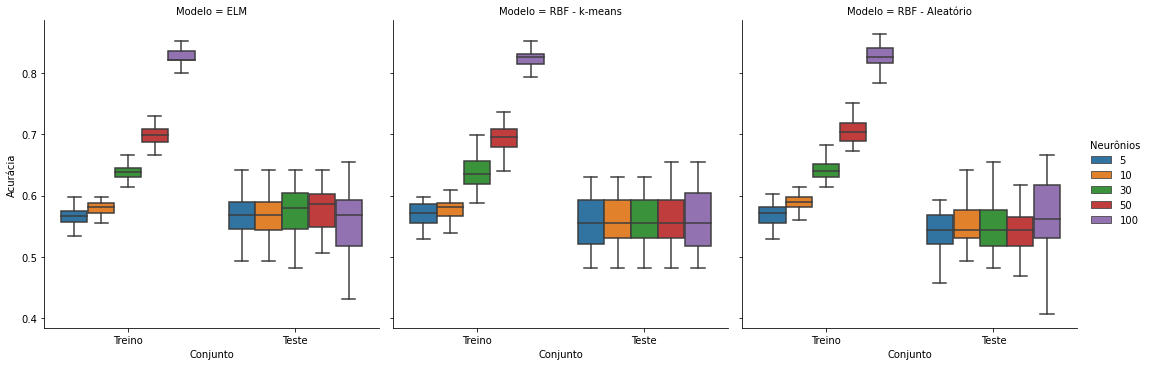

In [62]:
results_hd_elm['Modelo'] = 'ELM'
results_hd_rbfrandom['Modelo'] = 'RBF - Aleatório'
results_hd_rbfkmeans['Modelo'] = 'RBF - k-means'

results = pd.concat([results_hd_elm, results_hd_rbfkmeans, results_hd_rbfrandom], ignore_index=True)

sns.catplot(data=results, x='Conjunto',y='Acurácia', hue='Neurônios', col='Modelo', kind='box', showfliers=False)

display('Tabela: Acurácia Média e Desvio Padrão')
display(results.groupby(['Neurônios','Conjunto','Modelo'])['Acurácia'].agg([np.mean, np.std]))

A partir dos resultados acima, é possível concluir que:

* Os resultados são bem similares aos encontrados para a base de dados anterior: a acurácia média de treinamento cresce proporcionalmente com o número de neurônios, porém a acurácia de teste começa a reduzir com aproximadamente 30 neurônios.
* Nota-se que a acurácia de teste chega ao seu máximo considerando uma quantidade em torno de 30 neurônios. 
* Mais uma vez, fica claro que a quantidade de neurônios é um fator importante para se obter uma boa generalização com ELMs.

A seguir são exibidos os resultados do mesmo experimento considerando o RBF com inicialização via k-means.

## Parte 3: Comparação com o ELM

Um experimento similiar ao anterior é desenvolvido a seguir para avaliar o algoritmo ELM. Serão considerados os mesmos conjuntos de dados utilizados em cada repetição do experimento do RBF, de forma a se ter uma comparação mais justa entre os algoritmos.


## Conclusões

Por meio dos experimentos realizados neste exercício, foi possível constatar que ELMs são capazes de obter um bom desempenho nas bases de dados avaliadas. Entretanto, é importante notar que a escolha da quantidade de neurônios é um hiper-parâmetro que deve ser bem escolhido para se conseguir obter uma boa generalização. Os resultados mostram que o aumento da quantidade de neurônios irá levar ao over-fitting deste modelo. 

Outro resultado importante foi que o Perceptron, embora seja um modelo mais simples, foi capaz de obter resultados similares ao do ELM, com a vantagem de não necessitar do ajuste de nenhum hiper-parâmetro para obter uma boa generalização. Vale a pena ressaltar que as bases de dados consideradas são linermente separáveis, de forma que não podemos extrapolar este resultado para problemas que não possuem esta característica.